In [1]:
from PIL import Image
import zipfile
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from IPython import display
import datetime
import time

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import scipy.io as io
import keras_contrib

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [4]:
import gc



In [5]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''



In [6]:
tf.compat.v1.enable_eager_execution()

In [7]:
def Spade(num2,x,segmap,num):
    initializer=tf.random_normal_initializer(0,0.02)    
    x=tf.keras.layers.BatchNormalization()(x)
    segmap=tf.image.resize(segmap,[4*num,4*num])#调整图片大小
    segmap=tf.keras.layers.Conv2D(128,3,strides=1,padding='same',kernel_initializer=initializer,use_bias=False)(segmap)
    segmap=tf.keras.layers.ReLU()(segmap)
    
    gamma=tf.keras.layers.Conv2D(num2,3,strides=1,padding='same',kernel_initializer=initializer,use_bias=False)(segmap)
    
    beta=tf.keras.layers.Conv2D(num2,3,strides=1,padding='same',kernel_initializer=initializer,use_bias=False)(segmap)
    
    return (gamma+1)*x+beta
    

In [8]:
def Spade_ResBlk(num2,x,segmap,filters,num):
    initializer=tf.random_normal_initializer(0,0.02)
    
    
    x1=Spade(num2,x,segmap,num)
    x1=tf.keras.layers.LeakyReLU()(x1)
    x1=tf.keras.layers.Conv2D(filters,3,strides=1,padding='same',kernel_initializer=initializer,use_bias=False)(x1)
    
    
    x1=Spade(filters,x1,segmap,num)
    x1=tf.keras.layers.LeakyReLU()(x1)
    x1=tf.keras.layers.Conv2D(filters,3,strides=1,padding='same',kernel_initializer=initializer,use_bias=False)(x1)
    
    x=Spade(num2,x,segmap,num)
    x=tf.keras.layers.LeakyReLU()(x1)
    x=tf.keras.layers.Conv2D(filters,3,strides=1,padding='same',kernel_initializer=initializer,use_bias=False)(x1)
    
    x=x+x1
    
    return x
    

In [9]:
def encoder_block(filters):
    initializer=tf.random_normal_initializer(0,0.02)
    
    block=tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters,3,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    block.add(keras_contrib.layers.InstanceNormalization())
    block.add(tf.keras.layers.LeakyReLU())
    
    return block

In [10]:
b=[ 1.09398223e-01, -7.01745391e-01, -3.91475797e-01, -6.80442691e-01,
        1.01302110e-01, -2.06758165e+00, -6.15261076e-03,  1.38641715e+00,
       -2.16011858e+00, -4.80607837e-01, -5.36878824e-01,  6.61370993e-01,
        9.80835080e-01,  1.00194581e-01, -1.20660122e-02, -2.92659551e-01,
        1.90165401e+00, -3.55604917e-01, -3.41223150e-01,  9.20889914e-01,
       -4.10751253e-01, -3.04967910e-01,  4.59801555e-01, -9.15719122e-02,
        8.23659301e-02,  6.73895359e-01, -7.51458883e-01,  6.69990301e-01,
       -2.90337682e+00, -1.07552361e+00,  1.79552543e+00, -1.81808543e+00,
        1.68375921e+00,  3.00740331e-01,  1.24897063e+00,  1.54214501e-02,
       -2.21818113e+00, -6.40897080e-02, -8.21697235e-01, -1.34972692e-01,
        2.34940362e+00, -7.03830421e-01,  5.06786704e-01, -6.99196637e-01,
       -1.26937437e+00, -2.52861857e-01,  1.63582432e+00, -7.96311975e-01,
       -3.15868974e-01, -5.67130595e-02, -9.54037011e-02, -1.56947002e-01,
       -4.32539701e-01,  1.21812963e+00,  2.44811296e-01,  1.06517493e-03,
        5.37360191e-01, -3.14026233e-03, -4.55410331e-01,  1.50040537e-01,
       -1.65251696e+00,  8.37693751e-01, -8.84405971e-01, -8.05317521e-01,
        1.51757407e+00, -1.44158435e+00, -2.14658093e+00,  7.56792873e-02,
        1.08882594e+00,  7.18542516e-01,  9.70552444e-01, -1.62083730e-01,
        2.36011427e-02, -3.14742517e+00, -1.59132302e+00, -3.47380936e-01,
        1.08195893e-01, -1.51989698e-01, -2.19788939e-01,  1.27668834e+00,
        1.03366423e+00, -1.93199742e+00, -6.66437522e-02, -4.05270517e-01,
        8.54746938e-01,  1.92735076e+00, -6.11654878e-01,  2.68646866e-01,
       -6.33371532e-01,  3.76523793e-01,  7.92135119e-01, -1.49863124e+00,
       -4.46011536e-02,  4.74136055e-01,  1.02864766e+00,  8.89996469e-01,
        6.75564468e-01, -1.30954355e-01,  4.94244576e-01,  7.45899558e-01,
       -1.56613335e-01,  1.36730075e+00,  1.68628380e-01,  3.53314658e-03,
        9.03990090e-01,  1.40195444e-01,  9.85414833e-02,  4.19275254e-01,
       -3.36481519e-02,  2.45326549e-01,  3.54516953e-02, -1.18209696e+00,
       -8.56581450e-01, -7.61776924e-01, -1.38177598e+00, -2.66133845e-01,
        1.45023775e+00,  1.41912496e+00,  1.44648060e-01, -3.14437523e-02,
        6.65680051e-01,  3.58196586e-01, -3.91108215e-01, -5.19516408e-01,
        1.32320571e+00,  5.18085122e-01,  1.75068307e+00, -1.03100896e-01,
        1.83369660e+00, -3.15227365e+00, -1.65771887e-01,  1.35008901e-01,
        9.73028541e-01,  9.16363239e-01,  6.70804977e-02,  1.64290369e+00,
        1.10678589e+00,  7.80407131e-01, -7.64281154e-02,  9.81125057e-01,
        1.15349877e+00, -1.07952583e+00,  4.37276691e-01, -9.56526920e-02,
       -8.10703993e-01,  6.46177649e-01, -2.62691259e-01, -3.44538599e-01,
       -3.27624917e-01, -1.30278456e+00,  3.30004036e-01, -1.46936297e+00,
        8.58642533e-02,  2.49484509e-01,  1.05241692e+00,  2.04514652e-01,
        1.08832610e+00, -1.73757032e-01, -2.77286887e-01,  9.67025936e-01,
       -2.05639100e+00, -8.07983875e-01,  1.58234465e+00,  5.64972997e-01,
        5.91350913e-01, -1.40839130e-01, -5.42346776e-01,  1.33135033e+00,
       -2.24199295e-01, -4.79004979e-01,  6.44344151e-01, -1.65611947e+00,
       -4.11438584e-01, -1.14152487e-02, -1.81588328e+00, -6.95155025e-01,
       -2.41588354e-01,  1.52799892e+00, -1.07857645e+00, -2.46833473e-01,
       -7.85873115e-01,  1.19508058e-01, -7.70763695e-01,  2.64164233e+00,
        2.96800613e-01, -2.86061436e-01,  1.89369798e+00,  5.50864816e-01,
       -7.57534742e-01,  8.85300413e-02, -3.93872231e-01,  1.30517602e+00,
       -2.31828284e+00, -1.59819078e+00,  5.88336825e-01, -1.12500146e-01,
       -5.14462173e-01,  1.05639309e-01,  8.68221879e-01, -2.21772552e+00,
        8.25944364e-01, -4.18995500e-01, -4.38051373e-01, -1.35572326e+00,
        9.16148365e-01,  1.13186345e-01,  1.31754375e+00,  6.73261702e-01,
       -1.49814993e-01, -8.13537121e-01, -5.16351819e-01, -3.73705357e-01,
       -1.99787974e-01, -1.58680692e-01, -8.34456921e-01,  2.34511018e+00,
        9.11160409e-02, -6.41909719e-01,  8.30103934e-01, -2.39636656e-02,
       -1.19645226e+00,  8.12078118e-01,  5.57315767e-01, -2.54300666e+00,
        1.73908964e-01,  8.98634851e-01, -1.32860139e-01, -1.89663732e+00,
       -3.11678737e-01, -1.30957112e-01,  2.52645612e-01, -2.09982902e-01,
        2.66717339e+00,  3.40309769e-01,  4.76272643e-01, -4.87283617e-01,
       -3.59700948e-01, -1.54874396e+00,  6.54738843e-01,  6.31636143e-01,
        6.61850393e-01,  1.30487251e+00, -2.40038246e-01, -1.01502395e+00,
        2.06906533e+00,  2.23190635e-02, -8.87865841e-01, -2.24324360e-01,
        5.66155493e-01, -1.11572206e+00,  4.65975523e-01, -1.04832935e+00,
        1.58024025e+00,  1.57934809e+00,  6.82842553e-01,  9.98936415e-01]
b=tf.convert_to_tensor(b)

In [11]:
eps=b

In [12]:
def Image_Encoder():
    inputs=tf.keras.layers.Input(shape=[256,256,3])
    #风格编码
    initializer=tf.random_normal_initializer(0,0.02)
    encoder_blocks=[
        encoder_block(64),
        encoder_block(128),
        encoder_block(256),
        encoder_block(256),
        encoder_block(256),
        encoder_block(256)
    ]
    x=inputs
    for block in encoder_blocks:
        x=block(x)
    x=tf.keras.layers.Flatten()(x)
    
    x1=tf.keras.layers.Dense(256)(x)
    x2=tf.keras.layers.Dense(256)(x)
    
    std=tf.exp(x2*0.5)
    result=eps*std+x1
    
    return tf.keras.Model(inputs=inputs,outputs=result)

In [13]:
def GANGenerator():
    initializer=tf.random_normal_initializer(0,0.02)
    inputs=tf.keras.layers.Input(shape=[256,256,3])#语义标签
    inputs2=tf.keras.layers.Input(shape=[256])#target
   
    
    x1=inputs
    x2=inputs2
    

    x2=tf.keras.layers.Flatten()(x2)
    x2=tf.keras.layers.Dense(8192)(x2)
    x2=tf.reshape(x2,[-1,4,4,512])
    num=1
    x=Spade_ResBlk(512,x2,x1,512,num)
    x=tf.keras.layers.UpSampling2D(size=(2,2))(x)
    num=2
    x=Spade_ResBlk(512,x,x1,512,num)
    x=tf.keras.layers.UpSampling2D(size=(2,2))(x)
    num=4
    x=Spade_ResBlk(512,x,x1,256,num)
    x=tf.keras.layers.UpSampling2D(size=(2,2))(x)
    num=8
    x=Spade_ResBlk(256,x,x1,256,num)
    x=tf.keras.layers.UpSampling2D(size=(2,2))(x)
    num=16
    x=Spade_ResBlk(256,x,x1,256,num)
    x=tf.keras.layers.UpSampling2D(size=(2,2))(x)
    num=32
    x=Spade_ResBlk(256,x,x1,128,num)
    x=tf.keras.layers.UpSampling2D(size=(2,2))(x)
    num=64
    x=Spade_ResBlk(128,x,x1,64,num)
    
    x=tf.keras.layers.Conv2D(3,3,strides=1,padding='same',kernel_initializer=initializer,use_bias=False)(x)
    
    output=tf.tanh(x)
    
    return tf.keras.Model(inputs=[inputs,inputs2],outputs=output)

In [14]:
GANGenerator().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_ResizeBilinear (Ten [(None, 4, 4, 3)]    0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 4, 4, 128)    3456        tf_op_layer_ResizeBilinear[0][0] 
______________________________________________________________________________________________

In [15]:
def dis_block(filters):
    initializer=tf.random_normal_initializer(0,0.02)
    
    block=tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters,4,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    block.add(keras_contrib.layers.InstanceNormalization())
    block.add(tf.keras.layers.LeakyReLU())
    
    return block

In [16]:
def Discriminator():
    inputs=tf.keras.layers.Input(shape=[256,256,3])
    inputs2=tf.keras.layers.Input(shape=[256,256,3])
    x=tf.keras.layers.concatenate([inputs,inputs2])
    initializer=tf.random_normal_initializer(0,0.02)

    
    dis_blocks=[
        dis_block(64),
        dis_block(128),
        dis_block(256),
    ]
    for block in dis_blocks:
        x=block(x)
    x=tf.keras.layers.Conv2D(256,2,strides=1,padding='valid',kernel_initializer=initializer,use_bias=False)(x)
    x=keras_contrib.layers.InstanceNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Conv2D(256,2,strides=1,padding='valid',kernel_initializer=initializer,use_bias=False)(x)
    x1=tf.nn.sigmoid(x)
    
    return tf.keras.Model(inputs=[inputs,inputs2],outputs=x1)
    
    
    

In [17]:
Discriminator().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 6146        concatenate[0][0]          

In [18]:

model=tf.keras.applications.VGG19(input_shape=(256,256,3),weights='imagenet',include_top=False)
model.trainable=False
slice1=tf.keras.Sequential()
slice2=tf.keras.Sequential()
slice3=tf.keras.Sequential()
slice4=tf.keras.Sequential()
slice5=tf.keras.Sequential()

for i in range(4):
    slice1.add(model.layers[i])
for i in range(4,7):
    slice2.add(model.layers[i])
for i in range(7,12):
    slice3.add(model.layers[i])
for i in range(12,17):
    slice4.add(model.layers[i])
for i in range(17,22):
    slice5.add(model.layers[i])
    

In [19]:
def vgg19_input(image):
    x1=slice1(image)
    x2=slice2(x1)
    x3=slice3(x2)
    x4=slice4(x3)
    x5=slice5(x4)
    return [x1,x2,x3,x4,x5]

In [38]:
LAMBDA = 1/2
def generator_loss(target,gen_dis_image,gen_image):#gen_image:(512,512,3) 
    gan_loss=tf.reduce_mean(1/2*tf.square(gen_dis_image-1))
    
    weight=[1/32,1/16,1/8,1/4,1]
    x_1=vgg19_input(gen_image)
    x_11=vgg19_input(target)
    l1_loss=tf.reduce_mean(tf.abs(gen_image-target))
    for i in range(len(x_1)):
        l1_loss=l1_loss+weight[i]*tf.reduce_mean(tf.abs(x_1[i]-x_11[i]))
    total_gen_loss=gan_loss+LAMBDA*l1_loss
    print(gan_loss)
    print(LAMBDA*l1_loss)
    
    return total_gen_loss,l1_loss

In [21]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.reduce_mean(1/2*tf.square(disc_real_output-1))

    generated_loss = tf.reduce_mean(1/2*tf.square(disc_generated_output))

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
encoder_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [23]:
generator=GANGenerator()
discriminator=Discriminator()
encoder=Image_Encoder()

In [24]:
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape,tf.GradientTape() as encoder_tape:
        style=encoder(target,training=True)
        gen_output = generator([input_image,style], training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss,gen_l1_loss = generator_loss(target,disc_generated_output,gen_output)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
    encoder_gradients=encoder_tape.gradient(gen_l1_loss,
                                            encoder.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    encoder_optimizer.apply_gradients(zip(encoder_gradients,encoder.trainable_variables))

In [25]:
def generate_images(model,model2, test_input, target):
    style=model2(target,training=True)
    prediction = model([test_input,style], training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [26]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, w:, :]
    input_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image


In [27]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


In [28]:
# 目标尺寸
IMG_WIDTH = 256
IMG_HEIGHT = 256
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [29]:
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


In [30]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [31]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image


In [32]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [33]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
train_dataset = tf.data.Dataset.list_files('./data_coast/'+'*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [34]:
test_dataset = tf.data.Dataset.list_files('./test_coast/'+'*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [35]:
def fit(train_ds, epochs, test_ds):
    num=359

    

    for epoch in range(epochs):
        gc.collect()
        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, encoder,example_input, example_target)
        print("\r总进度完成%.2f %%" % (epoch *100 /epochs), end="")
        print()
        # Train
        if epoch!=0 and epoch%5==0:
                    generator.save('./Gaugan_coast%s.h5'%(epoch))
                    discriminator.save('./Gaugan_Discriminator_coast%s.h5'%(epoch))
                    encoder.save('./Gaugan_image_encoder_coast%s.h5'%(epoch))
                    print(epoch)
        for n, (input_image, target) in train_ds.enumerate():
            print("\r子进度完成%.2f %%" % (n *100 /num), end="")
            
            train_step(input_image, target, epoch)
        print()


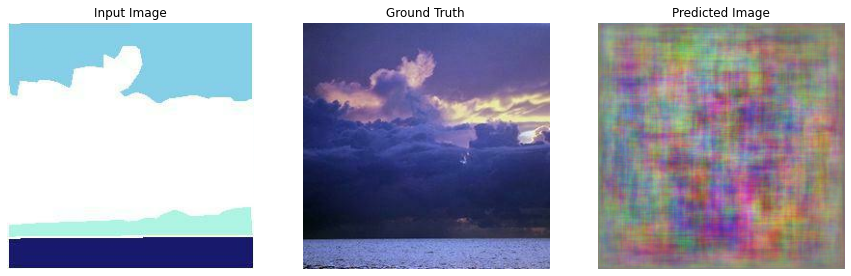

In [36]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator,encoder, example_input, example_target)

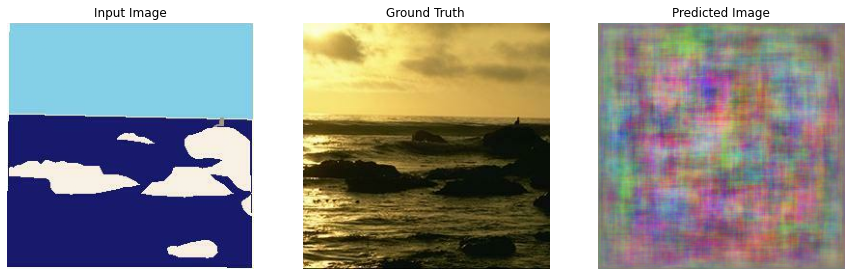

总进度完成0.00 %
子进度完成0.00 %tf.Tensor(0.12556317, shape=(), dtype=float32)
tf.Tensor(1.2016897, shape=(), dtype=float32)


ResourceExhaustedError: OOM when allocating tensor with shape[1,128,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput]

In [39]:
EPOCHS = 500
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
import line_profiler
 
def prime_num(max_num):
    for num in range(2, max_num):
        if num < 2:
            pass
        elif num == 2:
            pass
        else:
            for i in range(2, num):
                if num % i == 0:
                    break
            else:
                pass


#这将要运行的函数，放在中间
profile = line_profiler.LineProfiler(fit(train_dataset, EPOCHS, test_dataset))  # 把函数传递到性能分析器
profile.enable()  # 开始分析
prime_num(3000) # 要执行的函数放在这里，代码执行完自会打印耗时的信息
profile.disable()  # 停止分析
profile.print_stats()  # 打印出性能分析结果